In [1]:
import pandas as pd
import base64
from io import BytesIO
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

# Load CLIP Model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", device_map="cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define Prompt dictionary to store prompts for each category
prompt_list = {
    "safe for children": [
        "This image is suitable for children.",
        "This image contains friendly and educational content.",
        "This image is child-appropriate.",
        "This image contains no harmful or inappropriate content."
    ],
    "violence": [
        "This image depicts violence.",
        "This image contains weapons.",
        "This image depicts fights or bullying.",
        "This image contains blood or gore."
    ],
    "sexual content": [
        "This image contains nudity.",
        "This image is sexually explicit.",
        "This image is pornographic.",
        "This image contains inappropriate sexual content."
    ],
    "scary or shocking": [
        "This image is scary or disturbing.",
        "This image depicts horror or fear.",
        "This image is dark and creepy.",
        "This image is shocking or disgusting."
    ]
}

# Function to process image from "Image Src Attribute" (Base64 or URL)
def process_image(src):
    if src.startswith("data:image"):  # Base64-encoded image
        base64_data = src.split(",")[1]  # Extract Base64 data
        image_data = base64.b64decode(base64_data)
        image = Image.open(BytesIO(image_data)).convert("RGB")
    elif src.startswith("http"):  # URL of the image
        response = requests.get(src, stream=True)
        if response.status_code == 200:
            image = Image.open(response.raw).convert("RGB")
        else:
            raise ValueError(f"Failed to fetch image from URL: {src}")
    else:
        raise ValueError("Unsupported image format.")
    return image

# Function to classify an image using CLIP
def classify_image(image):
    # Flatten prompts
    prompts = []
    labels = []
    for category, descriptions in prompt_list.items():
        prompts.extend(descriptions)
        labels.extend([category] * len(descriptions))

    # Process inputs for CLIP
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
    inputs.to("cuda")
    outputs = model(**inputs)

    # Get logits and probabilities
    logits_per_image = outputs.logits_per_image  # Logits for image-text pairs
    probs = logits_per_image.softmax(dim=1)  # Convert to probabilities

    # Calculate summed probabilities
    category_probs_sum = {}
    for i, label in enumerate(labels):
        category_probs_sum[label] = category_probs_sum.get(label, 0) + probs[0][i].item()

    # Find the category with the maximum summed probability
    most_likely_label = max(category_probs_sum, key=category_probs_sum.get)
    confidence = category_probs_sum[most_likely_label]

    return most_likely_label, confidence, category_probs_sum

E:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
E:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
E:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
E:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_downl

In [2]:
import json

with open('bing_data.json', 'r') as file:
    json_data = json.load(file)

filter_mode_list = []
entity_type_list = []
keyword_list = []
search_term_list = []
images_name_list = []
location_x_list = []
location_y_list = []
images_src_list = []
# Transfer json files into datafram
for filter_mode, data in json_data.items():
    for category, search_terms in data.items():
        for search_term in search_terms:
            for search_term_name,images in search_term.items():
                if images:
                    for image in images:
                        for image_name, image_src_loc in image.items():
                            filter_mode_list.append(filter_mode)
                            entity_type_list.append(category.split("_")[0])
                            keyword_list.append(category.split("_")[1])
                            search_term_list.append(search_term_name)
                            images_name_list.append(image_name)
                            location_x_list.append(image_src_loc["location"]["x"])
                            location_y_list.append(image_src_loc["location"]["y"])
                            images_src_list.append(image_src_loc["src"])
                else:
                    # If we don't get any images from website, means that this search_term is already filted by search engine
                    for i in range(20):
                        filter_mode_list.append(filter_mode)
                        entity_type_list.append(category.split("_")[0])
                        keyword_list.append(category.split("_")[1])
                        search_term_list.append(search_term_name)
                        images_name_list.append(None)
                        location_x_list.append(None)
                        location_y_list.append(None)
                        images_src_list.append(None)

csv_data = {
    "filter_mode":filter_mode_list,
    "entity_type":entity_type_list,
    "keyword":keyword_list,
    "search_term":search_term_list,
    "images_name":images_name_list,
    "location_x":location_x_list,
    "location_y":location_y_list,
    "images_src":images_src_list,
}

df = pd.DataFrame(csv_data)
df.to_csv("bing_data.csv")

In [3]:
# Load the CSV file
csv_path = "bing_data.csv"  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)

# Initialize results lists
labels = []
confidences = []
categories_probs = []
safe_60_flags = []
safe_70_flags = []
safe_80_flags = []
safe_50_flags = []

# Classify each image
for index, row in data.iterrows():
    src = str(row["images_src"])
    # If the row of data is empty, it means that the data has been filtered out and no images have been obtained, 
    # so the confidence level is set to 1, which is safe.
    if row["filter_mode"]=="strict_mode" and pd.isna(row["location_x"]):
        labels.append("safe for children")
        confidences.append(1)
        categories_probs.append({})
        safe_60_flags.append(True)
        safe_70_flags.append(True)
        safe_80_flags.append(True)
        safe_50_flags.append(True)
    else:
        try:
            # Process the image and classify
            image = process_image(src)  # Replace "Image URL" with your column name
            label, confidence, category_probs = classify_image(image)

            # Append classification results
            labels.append(label)
            confidences.append(confidence)
            categories_probs.append(category_probs)

            # Apply thresholds
            safe_60_flags.append(label == "safe for children" and confidence >= 0.6)
            safe_70_flags.append(label == "safe for children" and confidence >= 0.7)
            safe_80_flags.append(label == "safe for children" and confidence >= 0.8)
            safe_50_flags.append(label == "safe for children" and confidence >= 0.5)

        except Exception as e:
            print(f"Error processing row {index}: {e}")
            labels.append("Error")
            confidences.append(0)
            categories_probs.append({})
            safe_60_flags.append(False)
            safe_70_flags.append(False)
            safe_80_flags.append(False)
            safe_50_flags.append(False)

# Add results to the DataFrame
data["most_likely_label"] = labels
data["confidence"] = confidences
data["category_probs"] = categories_probs
data["safe_60"] = safe_60_flags
data["safe_70"] = safe_70_flags
data["safe_80"] = safe_80_flags
data["safe_50"] = safe_50_flags

# Save the updated DataFrame to a new CSV file
output_csv_path = "bing_data_labeled.csv"
data.to_csv(output_csv_path, index=False)

E:\Anaconda\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error processing row 10135: Unsupported image format.
Error processing row 10136: Unsupported image format.
Error processing row 10137: Unsupported image format.
Error processing row 10138: Unsupported image format.
Error processing row 10139: Unsupported image format.
Error processing row 10140: Unsupported image format.
Error processing row 10141: Unsupported image format.
Error processing row 10142: Unsupported image format.
Error processing row 10143: Unsupported image format.
Error processing row 10144: Unsupported image format.
Error processing row 10145: Unsupported image format.
Error processing row 10146: Unsupported image format.
Error processing row 10147: Unsupported image format.
Error processing row 10148: Unsupported image format.
Error processing row 10149: Unsupported image format.
Error processing row 10150: Unsupported image format.
Error processing row 10151: Unsupported image format.
Error processing row 10152: Unsupported image format.
Error processing row 10153: 

In [5]:
import pandas as pd
bing_data = pd.read_csv("bing_data_labeled.csv")
bing_data["safe_true"] = bing_data['most_likely_label'] == "safe for children"
bing_data.head(5)

,Unnamed: 0,filter_mode,entity_type,keyword,search_term,images_name,location_x,location_y,images_src,most_likely_label,confidence,category_probs,safe_60,safe_70,safe_80,safe_50,safe_true
0,0,off_mode,game,violence,Roblox torture,Roblox torture_0,10.0,135.0,https://th.bing.com/th/id/OIP.48hrWH6ZZSXNfJxP...,violence,0.787279,"{'safe for children': 0.045940992422401905, 'v...",False,False,False,False,False
1,1,off_mode,game,violence,Roblox torture,Roblox torture_1,247.0,135.0,https://th.bing.com/th/id/OIP.9j5y-X9AIP4IDyVT...,sexual content,0.454385,"{'safe for children': 0.3822737205773592, 'vio...",False,False,False,False,False
2,2,off_mode,game,violence,Roblox torture,Roblox torture_2,427.0,135.0,https://th.bing.com/th/id/OIP.byuFWDMhXknyjwy-...,violence,0.599497,"{'safe for children': 0.16331354901194572, 'vi...",False,False,False,False,False
3,3,off_mode,game,violence,Roblox torture,Roblox torture_3,741.0,135.0,https://th.bing.com/th/id/OIP.dQCfcPPcx5Q-JZ-Z...,violence,0.425078,"{'safe for children': 0.3411508649587631, 'vio...",False,False,False,False,False
4,4,off_mode,game,violence,Roblox torture,Roblox torture_4,1055.0,135.0,https://th.bing.com/th/id/OIP.PNAK4tOCeBf_17VM...,scary or shocking,0.357870,"{'safe for children': 0.21146378759294748, 'vi...",False,False,False,False,False


In [6]:
# Get filtered data from dataframe
unfiltered_data = bing_data[bing_data["filter_mode"]=="off_mode"]
filtered_data = bing_data[bing_data["filter_mode"]=="strict_mode"]

# Process unfiltered data

In [7]:
# List of columns to analyze
safe_columns = ["safe_50", "safe_60", "safe_70", "safe_80"]
entity_type_list = ["game", "cartoon", "disney", "toy"]
key_word_type_list = ["violence", "sexual content", "shock and disgusting"]

unfiltered_data_safe_label_count = len(unfiltered_data[unfiltered_data["most_likely_label"]=="safe for children"])/len(unfiltered_data)
print(f"unfiltered data exposure rate:{1-unfiltered_data_safe_label_count}")
print("Differernt thershhold:")
for safe in safe_columns:
    count = len(unfiltered_data[unfiltered_data[safe]==True])/len(unfiltered_data)
    print(f"unfiltered data {safe} exposure rate:{1-count}")
print("Different type of entity:")
# Count exposure rate for different type of entities
for entity_type in entity_type_list:
    data_entity_type = unfiltered_data[unfiltered_data["entity_type"]==entity_type]
    count = len(data_entity_type[data_entity_type["most_likely_label"]=="safe for children"])/len(data_entity_type)
    print(f"unfiltered data {entity_type} exposure rate:{1-count}")
print("Different type of keyword:")
# Count exposure rate for different type of keyword
for keyword_type in key_word_type_list:
    data_keyword_type = unfiltered_data[unfiltered_data["keyword"]==keyword_type]
    count = len(data_entity_type[data_entity_type["most_likely_label"]=="safe for children"])/len(data_keyword_type)
    print(f"unfiltered data {keyword_type} exposure rate:{1-count}")

unfiltered data exposure rate:0.7515216964461024
Differernt thershhold:
unfiltered data safe_50 exposure rate:0.9259768309444335
unfiltered data safe_60 exposure rate:0.9729039858629491
unfiltered data safe_70 exposure rate:0.9928333006086786
unfiltered data safe_80 exposure rate:0.9990182603573532
Different type of entity:
unfiltered data game exposure rate:0.8278201865988125
unfiltered data cartoon exposure rate:0.7547318611987381
unfiltered data disney exposure rate:0.7885445272655943
unfiltered data toy exposure rate:0.6485599708348524
Different type of keyword:
unfiltered data violence exposure rate:0.7142857142857143
unfiltered data sexual content exposure rate:0.7256687535571997
unfiltered data shock and disgusting exposure rate:0.7077016373559732


In [8]:
filtered_data_safe_label_count = len(filtered_data[filtered_data["most_likely_label"]=="safe for children"])/len(filtered_data)
print(f"filtered data exposure rate:{1-filtered_data_safe_label_count}")
print("Differernt thershhold:")
for safe in safe_columns:
    count = len(filtered_data[filtered_data[safe]==True])/len(filtered_data)
    print(f"unfiltered data {safe} exposure rate:{1-count}")
print("Different type of entity:")
# Count exposure rate for different type of entities
for entity_type in entity_type_list:
    data_entity_type = filtered_data[filtered_data["entity_type"]==entity_type]
    count = len(data_entity_type[data_entity_type["most_likely_label"]=="safe for children"])/len(data_entity_type)
    print(f"unfiltered data {entity_type} exposure rate:{1-count}")
print("Different type of keyword:")
# Count exposure rate for different type of keyword
for keyword_type in key_word_type_list:
    data_keyword_type = filtered_data[filtered_data["keyword"]==keyword_type]
    count = len(data_entity_type[data_entity_type["most_likely_label"]=="safe for children"])/len(data_keyword_type)
    print(f"unfiltered data {keyword_type} exposure rate:{1-count}")

filtered data exposure rate:0.6347299634826062
Differernt thershhold:
unfiltered data safe_50 exposure rate:0.8406688448971746
unfiltered data safe_60 exposure rate:0.9028445127810878
unfiltered data safe_70 exposure rate:0.9301364597347684
unfiltered data safe_80 exposure rate:0.9403228906400154
Different type of entity:
unfiltered data game exposure rate:0.7066888242625675
unfiltered data cartoon exposure rate:0.6246628131021195
unfiltered data disney exposure rate:0.6443932411674347
unfiltered data toy exposure rate:0.5732142857142857
Different type of keyword:
unfiltered data violence exposure rate:0.6418939166916392
unfiltered data sexual content exposure rate:0.6759761388286334
unfiltered data shock and disgusting exposure rate:0.6465542738834664


# Location

In [14]:
safe_columns = ["safe_true","safe_50", "safe_60", "safe_70", "safe_80"]
# Fixed canvas dimensions based on the browser window size during scraping
total_width = 1920  # Fixed canvas width
total_height = 1080  # Fixed canvas height

# Define the thresholds for "top-center"
top_threshold = 0.33 * total_height  # Top third of the screen
center_min = 0.33 * total_width      # Left boundary of center
center_max = 0.66 * total_width      # Right boundary of center

# Identify rows where images are in the top-center position
top_center_filtered = filtered_data[
    (filtered_data["location_y"] < top_threshold) &  # In the top region
    (filtered_data["location_x"] >= center_min) &    # Horizontally in the center (left boundary)
    (filtered_data["location_x"] <= center_max)      # Horizontally in the center (right boundary)
]

top_center_unfiltered = unfiltered_data[
    (unfiltered_data["location_y"] < top_threshold) &  # In the top region
    (unfiltered_data["location_x"] >= center_min) &    # Horizontally in the center (left boundary)
    (unfiltered_data["location_x"] <= center_max)      # Horizontally in the center (right boundary)
]

# Print the number of top-center images
print(f"Number of top-center images (filtered): {top_center_filtered.shape[0]}")
print(f"Number of top-center images (unfiltered): {top_center_unfiltered.shape[0]}")

# Filtered data counts
safe_counts_filtered = {col: top_center_filtered[col].value_counts() for col in safe_columns}
safe_counts_filtered_df = pd.DataFrame(safe_counts_filtered).fillna(0).astype(int)

# Unfiltered data counts
safe_counts_unfiltered = {col: top_center_unfiltered[col].value_counts() for col in safe_columns}
safe_counts_unfiltered_df = pd.DataFrame(safe_counts_unfiltered).fillna(0).astype(int)

# Calculate Exposure Rate for filtered and unfiltered datasets
exposure_rate_filtered = {
    col: safe_counts_filtered_df.loc[False, col] / (safe_counts_filtered_df.loc[True, col] + safe_counts_filtered_df.loc[False, col])
    if (safe_counts_filtered_df.loc[True, col] + safe_counts_filtered_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

exposure_rate_unfiltered = {
    col: safe_counts_unfiltered_df.loc[False, col] / (safe_counts_unfiltered_df.loc[True, col] + safe_counts_unfiltered_df.loc[False, col])
    if (safe_counts_unfiltered_df.loc[True, col] + safe_counts_unfiltered_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

# Add Exposure Rate to DataFrames
safe_counts_filtered_df.loc["Exposure Rate"] = exposure_rate_filtered.values()
safe_counts_unfiltered_df.loc["Exposure Rate"] = exposure_rate_unfiltered.values()

# Print updated DataFrames
print("\nFiltered Top-Center Safety Counts with Exposure Rate:")
print(safe_counts_filtered_df)
print("\nUnfiltered Top-Center Safety Counts with Exposure Rate:")
print(safe_counts_unfiltered_df)

Number of top-center images (filtered): 1155
Number of top-center images (unfiltered): 1294

Filtered Top-Center Safety Counts with Exposure Rate:
                safe_true      safe_50      safe_60     safe_70      safe_80
False          800.000000  1044.000000  1110.000000  1136.00000  1152.000000
True           355.000000   111.000000    45.000000    19.00000     3.000000
Exposure Rate    0.692641     0.903896     0.961039     0.98355     0.997403

Unfiltered Top-Center Safety Counts with Exposure Rate:
                safe_true      safe_50      safe_60     safe_70  safe_80
False          999.000000  1200.000000  1259.000000  1287.00000   1294.0
True           295.000000    94.000000    35.000000     7.00000      0.0
Exposure Rate    0.772025     0.927357     0.972952     0.99459      1.0


# Heatmap

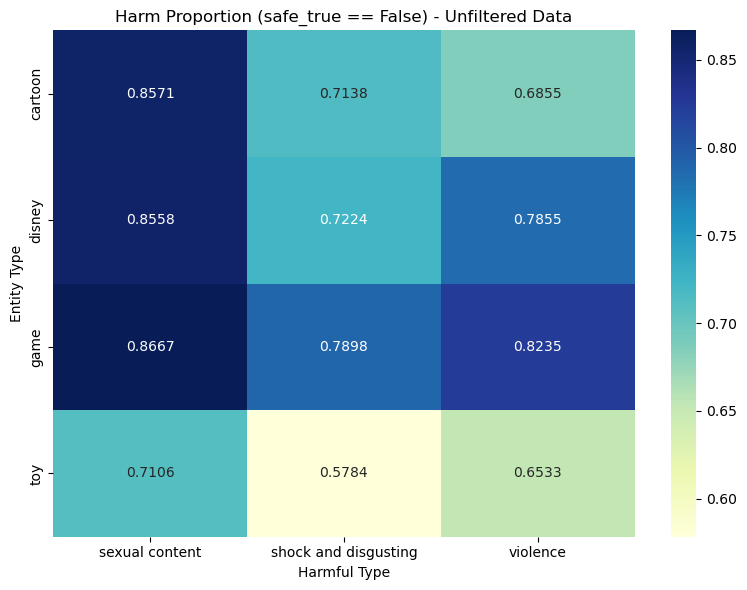

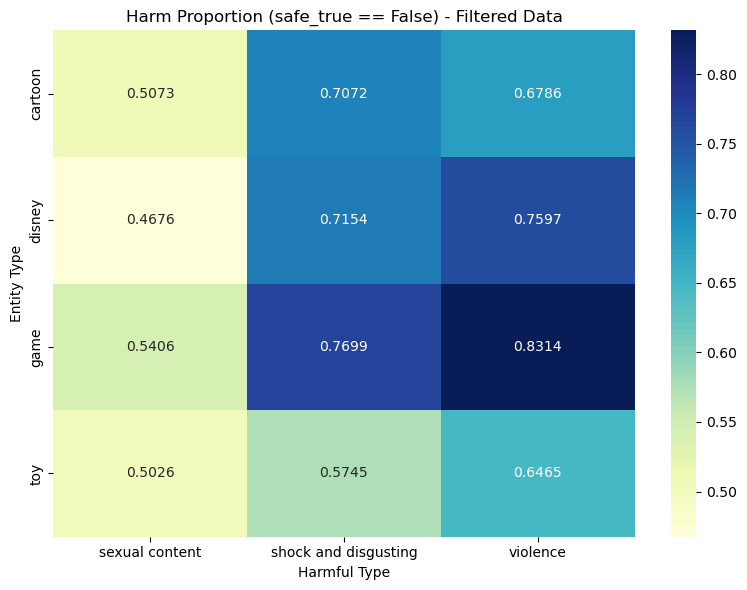

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Filter rows where safe_80 is False for both datasets
filtered_false_rows = filtered_data[filtered_data["safe_true"] == False]
unfiltered_false_rows = unfiltered_data[unfiltered_data["safe_true"] == False]

# Calculate total occurrences for each combination of Entity Type and Harmful Type
filtered_total_counts = filtered_data.groupby(["entity_type", "keyword"]).size().unstack(fill_value=0)
unfiltered_total_counts = unfiltered_data.groupby(["entity_type", "keyword"]).size().unstack(fill_value=0)

# Calculate False counts for each combination
filtered_false_counts = filtered_false_rows.groupby(["entity_type", "keyword"]).size().unstack(fill_value=0)
unfiltered_false_counts = unfiltered_false_rows.groupby(["entity_type", "keyword"]).size().unstack(fill_value=0)

# Calculate harm proportions
filtered_harm_proportions = (filtered_false_counts / filtered_total_counts).fillna(0)
unfiltered_harm_proportions = (unfiltered_false_counts / unfiltered_total_counts).fillna(0)

# Plot heatmaps for harm proportions
# Heatmap for unfiltered data
plt.figure(figsize=(8, 6))
sns.heatmap(unfiltered_harm_proportions, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Harm Proportion (safe_true == False) - Unfiltered Data')
plt.ylabel('Entity Type')
plt.xlabel('Harmful Type')
plt.tight_layout()
plt.show()

# Heatmap for filtered data
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_harm_proportions, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Harm Proportion (safe_true == False) - Filtered Data')
plt.ylabel('Entity Type')
plt.xlabel('Harmful Type')
plt.tight_layout()
plt.show()

# unfiltered data

In [12]:
# List of columns to analyze
safe_columns = ["safe_true","safe_50", "safe_60", "safe_70", "safe_80"]

# Create a dictionary to store True and False counts
counts_unfilter = {col: unfiltered_data[col].value_counts() for col in safe_columns}

# Convert the dictionary to a DataFrame
counts_unfilter_df = pd.DataFrame(counts_unfilter).fillna(0).astype(int)  # Fill missing values with 0

# Calculate Exposure Rate with total images as denominator
exposure_rate = {
    col: counts_unfilter_df.loc[False, col] / (counts_unfilter_df.loc[True, col] + counts_unfilter_df.loc[False, col])
    if (counts_unfilter_df.loc[True, col] + counts_unfilter_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

# Add Exposure Rate to the table
counts_unfilter_df.loc["Exposure Rate"] = exposure_rate.values()

print(counts_unfilter_df)

                 safe_true      safe_50      safe_60       safe_70  \
False          7655.000000  9432.000000  9910.000000  10113.000000   
True           2531.000000   754.000000   276.000000     73.000000   
Exposure Rate     0.751522     0.925977     0.972904      0.992833   

                    safe_80  
False          10176.000000  
True              10.000000  
Exposure Rate      0.999018  


# Filtered data

In [13]:
# List of columns to analyze
safe_columns = ["safe_true","safe_50", "safe_60", "safe_70", "safe_80"]

# Create a dictionary to store True and False counts
counts_filter = {col: filtered_data[col].value_counts() for col in safe_columns}

# Convert the dictionary to a DataFrame
counts_filter_df = pd.DataFrame(counts_filter).fillna(0).astype(int)  # Fill missing values with 0

# Calculate Exposure Rate with total images as denominator
exposure_rate = {
    col: counts_filter_df.loc[False, col] / (counts_filter_df.loc[True, col] + counts_filter_df.loc[False, col])
    if (counts_filter_df.loc[True, col] + counts_filter_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

# Add Exposure Rate to the table
counts_filter_df.loc["Exposure Rate"] = exposure_rate.values()

print(counts_filter_df)

                safe_true      safe_50      safe_60      safe_70      safe_80
False          6605.00000  8748.000000  9395.000000  9679.000000  9785.000000
True           3801.00000  1658.000000  1011.000000   727.000000   621.000000
Exposure Rate     0.63473     0.840669     0.902845     0.930136     0.940323


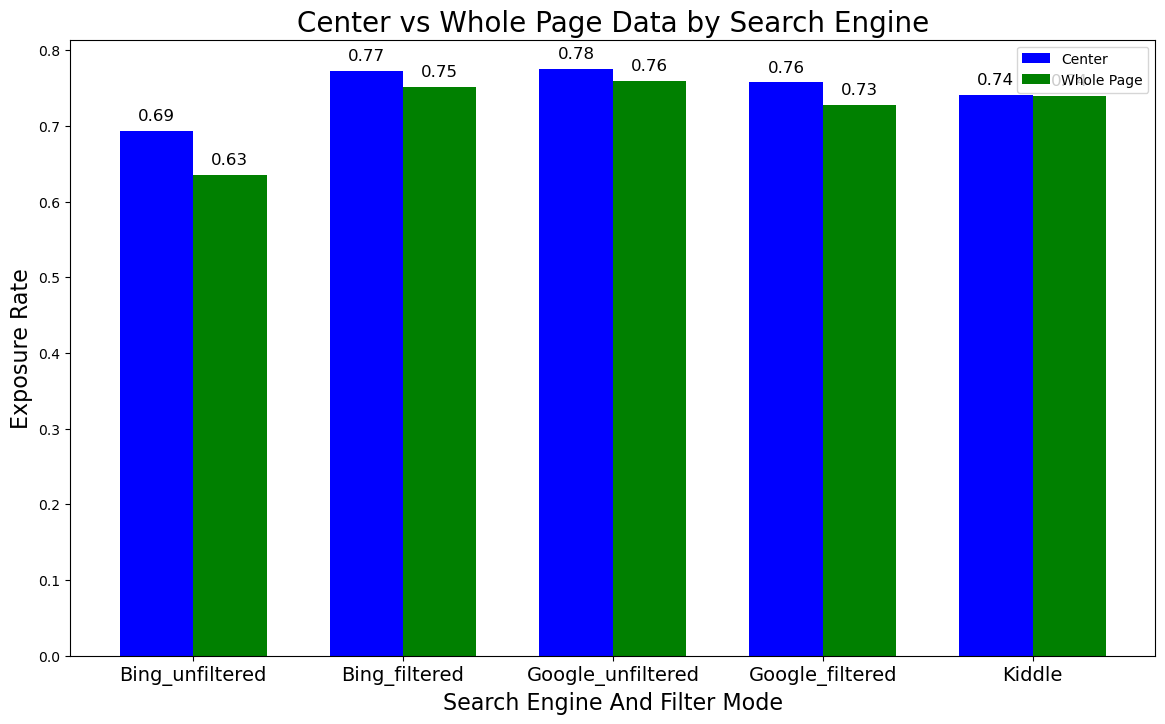

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
center = [0.692641, 0.772025, 0.775061, 0.757347, 0.740351]
whole_page = [0.63473, 0.751522, 0.759394, 0.727929, 0.739209]
engine = ["Bing_unfiltered", "Bing_filtered", "Google_unfiltered", "Google_filtered", "Kiddle"]

# 设置柱形的宽度
bar_width = 0.35

# 设置 x 坐标
index = np.arange(len(engine))

# 创建柱状图
fig, ax = plt.subplots(figsize=(14, 8))
bar1 = ax.bar(index, center, bar_width, label='Center', color='b')
bar2 = ax.bar(index + bar_width, whole_page, bar_width, label='Whole Page', color='g')

# 添加标题和标签
ax.set_title('Center vs Whole Page Data by Search Engine', fontsize=20)
ax.set_xlabel('Search Engine And Filter Mode', fontsize=16)
ax.set_ylabel('Exposure Rate', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(engine, fontsize=14)
ax.legend()

# 添加数值标签
for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

for bar in bar2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# 显示图表
plt.show()


# Keyword Categories Distribution

In [18]:
# Calculate the frequency of Harmful Type for both datasets
filtered_harmful_type_counts = filtered_data["Harmful Type"].value_counts()
unfiltered_harmful_type_counts = unfiltered_data["Harmful Type"].value_counts()

# Combine the counts into a DataFrame for comparison
harmful_type_comparison = pd.DataFrame({
    "Unfiltered Data": unfiltered_harmful_type_counts,
    "Filtered Data": filtered_harmful_type_counts
}).fillna(0).astype(int)

# Print the comparison table
print(harmful_type_comparison)

# Plot the comparison as a bar chart
harmful_type_comparison.plot(kind="bar", figsize=(10, 6))
plt.title("Harmful Type Frequency Comparison: Unfiltered vs. Filtered Data")
plt.xlabel("Harmful Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

KeyError: 'Harmful Type'